# <span style="color:#bcff8f"> Week 7 Assignment</span>

<span style="font-size:12pt;color:gray;font-weight:bold"> Patrick Weatherford</span><br>

<span style="font-size:16pt">Variable Relationship & Estimation</span>

***
http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

***

<br>

<br>
Setting working directory to ThinkStats2 directory

In [1]:
import os

# changing working directory to ThinkStats2/code folder
path = os.path.expanduser('~') + '\\OneDrive - Bellevue University\\Bellevue_University\\DSC 530 - Data Exploration and Analysis\\ThinkStats2\\code'
os.chdir(path)

<br>

Importing libraries

In [2]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nsfg
import first
import analytic
import thinkstats2
import thinkplot
import density
import hinc
import brfss
import bisect
import scipy.stats as stats
from pprint import pprint
import pandas as pd
import math
from statistics import median as med


Custom Functions

In [3]:
def freq_array(array, remove_na=True):
    if remove_na:
        array = array[~(np.isnan(array))]
    else:
        pass
        
    val, freq = np.unique(array, return_counts=True)  # Returns sorted unique values in array with frequency
    return freq
    
    
    
def unique_val_array(array, remove_na=True):
    if remove_na:
        array = array[~(np.isnan(array))]
    else:
        pass

    return np.unique(array)  # Returns sorted unique values in array
    
    
    
def cdf_array(array, remove_na=True):
    if remove_na:
        array = array[~(np.isnan(array))]
    else:
        pass
    
    val, freq = np.unique(array, return_counts=True)
    prob = freq/len(array)

    cdf = np.cumsum(prob)
    return (val, cdf)



def cdf_percentile(array, percentile, remove_na=True):
    percentile = percentile/100
    
    index = bisect.bisect_left(array[1], percentile)
    return array[0][index]



def cov_cor(x, y, sample=True):
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)-1 if sample else len(x)

    x_mean = np.mean(x)
    y_mean = np.mean(y)

    x_var = np.sum((x-x_mean)**2) / n
    y_var = np.sum((y-y_mean)**2) / n

    x_std = math.sqrt(x_var)
    y_std = math.sqrt(y_var)

    p_cov = np.dot(x-x_mean, y-y_mean) / n
    p_cor = p_cov / math.sqrt(x_var * y_var)

    return p_cov, p_cor



def cov_cor_stats(x, y, sample=True):
    x=np.asarray(x)
    y=np.asarray(y)
    
    x_rank = np.asarray(pd.Series(x).rank())
    y_rank = np.asarray(pd.Series(y).rank())
    
    ## Pearson's r
    p_cov, p_cor = cov_cor(x=x, y=y, sample=sample)
    
    
    # Spearman's r
    s_cov, s_cor = cov_cor(x=x_rank, y=y_rank, sample=sample)
    
    # Kendall's tau
    k_tau, k_pval = stats.kendalltau(x_rank, y_rank)
    
    cor_cov_dict = {
        "Covariance":p_cov
        , "Pearson's product-moment":p_cor
        , "Spearman's rho":s_cor
        , "Kendall's tau":k_tau
    }
    
    return cor_cov_dict



def error_est(sampling_dist_stat, observed_stat, error_type):
    error2 = [(simulated_stat_i - observed_stat)**2 for simulated_stat_i in sampling_dist_stat]
    mse = np.mean(error2)
    rmse = math.sqrt(mse)
    
    if error_type == 'rmse':
        return rmse
    elif error_type == 'mse':
        return mse
    else:
        return 'n/a'



def stat_est_ci(stat_list, lower=2.5, upper=97.5, rnd=5):
    array = np.asarray(stat_list)
    cdf = cdf_array(array)
    ci = round(cdf_percentile(cdf, lower),rnd), round(cdf_percentile(cdf, upper),rnd), round(cdf_percentile(cdf, upper) - cdf_percentile(cdf, lower),rnd)
    
    return ci
    


def dist_estimate(sample, dist='normal', iterations=1000, rnd=5):
    div = '-----'
    sample = np.asarray(sample)
    n = sample.size
    mean = np.mean(sample)
    median = med(sample)
    var = np.var(sample, ddof=0)
    std = np.std(sample, ddof=0)
    lamb = 1/mean
    est_median = math.log(2) / median
    
    stat_est_dict = {
        'RMSE':{
            'mean':None
            , 'median':None
            , 'var_n':None
            , 'var_n-1':None
            , 'std_n':None
            , 'std_n-1':None
            , 'lamb':None
            , 'exp_est_median':None
        }
        , 'MSE':{
            'mean':None
            , 'median':None
            , 'var_n':None
            , 'var_n-1':None
            , 'std_n':None
            , 'std_n-1':None
            , 'lamb':None
            , 'exp_est_median':None
        }
        , 'CI':{
            'mean':None
            , 'median':None
            , 'var_n':None
            , 'var_n-1':None
            , 'std_n':None
            , 'std_n-1':None
            , 'lamb':None
            , 'exp_est_median':None
        }
    }
    
    stat_dict = {
        'means':[]
        , 'medians':[]
        , 'vars_n':[]
        , 'vars_n-1':[]
        , 'stds_n':[]
        , 'stds_n-1':[]
        , 'lambs':[]
        , 'exp_est_medians':[]
    }
    
    sample_stat_dict = {
        'mean':round(mean,rnd)
        , 'median':round(median,rnd)
        , 'var':round(var,rnd)
        , 'std':round(std,rnd)
        , 'lamb':round(lamb,rnd)
        , 'exp_est_median':round(est_median,rnd)
    }
    
    
    for _ in range(iterations):
        if dist=='normal':
            x = [np.random.normal(loc=mean, scale=std, size=n)]
            stat_dict['means'].append(np.mean(x))
            stat_dict['medians'].append(med(x))
            stat_dict['vars_n'].append(np.var(x, ddof=0))
            stat_dict['vars_n-1'].append(np.var(x, ddof=1))
            stat_dict['stds_n'].append(np.std(x, ddof=0))
            stat_dict['stds_n-1'].append(np.std(x, ddof=1))
            stat_dict['lambs'].append(1/np.mean(x))
            stat_dict['exp_est_medians'].append(math.log(2) / med(x))
            
        elif dist=='exponential':
            x = [np.random.exponential(scale=1/lamb, size=n)]
            stat_dict['means'].append(np.mean(x))
            stat_dict['medians'].append(med(x))
            stat_dict['vars_n'].append(np.var(x, ddof=0))
            stat_dict['vars_n-1'].append(np.var(x, ddof=1))
            stat_dict['stds_n'].append(np.std(x, ddof=0))
            stat_dict['stds_n-1'].append(np.std(x, ddof=1))
            stat_dict['lambs'].append(1/np.mean(x))
            stat_dict['exp_est_medians'].append(math.log(2) / med(x))
            
            
    stat_est_dict['CI']['mean'] = stat_est_ci(stat_dict['means'],rnd)
    stat_est_dict['CI']['median'] = stat_est_ci(stat_dict['medians'],rnd)
    stat_est_dict['CI']['var_n'] = stat_est_ci(stat_dict['vars_n'],rnd)
    stat_est_dict['CI']['var_n-1'] = stat_est_ci(stat_dict['vars_n-1'],rnd)
    stat_est_dict['CI']['std_n'] = stat_est_ci(stat_dict['stds_n'],rnd)
    stat_est_dict['CI']['std_n-1'] = stat_est_ci(stat_dict['stds_n-1'],rnd)
    stat_est_dict['CI']['lamb'] = stat_est_ci(stat_dict['lambs'],rnd)
    stat_est_dict['CI']['exp_est_median'] = stat_est_ci(stat_dict['exp_est_medians'],rnd)
    stat_est_dict['RMSE']['mean'] = round(error_est(stat_dict['means'], mean, error_type='rmse'),rnd)
    stat_est_dict['RMSE']['median'] = round(error_est(stat_dict['medians'], median, error_type='rmse'),rnd)
    stat_est_dict['RMSE']['var_n'] = round(error_est(stat_dict['vars_n'], var, error_type='rmse'),rnd)
    stat_est_dict['RMSE']['var_n-1'] = round(error_est(stat_dict['vars_n-1'], var, error_type='rmse'),rnd)
    stat_est_dict['RMSE']['std_n'] = round(error_est(stat_dict['stds_n'], std, error_type='rmse'),rnd)
    stat_est_dict['RMSE']['std_n-1'] = round(error_est(stat_dict['stds_n-1'], std, error_type='rmse'),rnd)
    stat_est_dict['RMSE']['lamb'] = round(error_est(stat_dict['lambs'], lamb, error_type='rmse'),rnd)
    stat_est_dict['RMSE']['exp_est_median'] = round(error_est(stat_dict['exp_est_medians'], est_median, error_type='rmse'),rnd)
    stat_est_dict['MSE']['mean'] = round(error_est(stat_dict['means'], mean, error_type='mse'),rnd)
    stat_est_dict['MSE']['median'] = round(error_est(stat_dict['medians'], median, error_type='mse'),rnd)
    stat_est_dict['MSE']['var_n'] = round(error_est(stat_dict['vars_n'], var, error_type='mse'),rnd)
    stat_est_dict['MSE']['var_n-1'] = round(error_est(stat_dict['vars_n-1'], var, error_type='mse'),rnd)
    stat_est_dict['MSE']['std_n'] = round(error_est(stat_dict['stds_n'], std, error_type='mse'),rnd)
    stat_est_dict['MSE']['std_n-1'] = round(error_est(stat_dict['stds_n-1'], std, error_type='mse'),rnd)
    stat_est_dict['MSE']['lamb'] = round(error_est(stat_dict['lambs'], lamb, error_type='mse'),rnd)
    stat_est_dict['MSE']['exp_est_median'] = round(error_est(stat_dict['exp_est_medians'], est_median, error_type='mse'),rnd)
    
    
    # return stat_error_dict, sample_stat_dict
    print(f'Simulated Distribution: {dist.upper()}\n\nObserved Sample Statistics\n{div*5}')
    for stat, value in sample_stat_dict.items():
        print(f"{stat}: {value}")
        
    print(f'\n\nRMSE\n{div*5}')
    for stat, value in stat_est_dict['RMSE'].items():
        print(f"{stat}: {value}")
        
    print(f'\n\nCI\n{div*5}')
    for stat, value in stat_est_dict['CI'].items():
        print(f"{stat}: {value}")
        
    print(f'\n\nMSE\n{div*5}')
    for stat, value in stat_est_dict['MSE'].items():
        print(f"{stat}: {value}")
        
    
    


<br><br>

Load sample

In [4]:
df = brfss.ReadBrfss(nrows=None)

sample = thinkstats2.SampleRows(df, 5000)

heights, weights = sample.htm3, sample.wtkg2

import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

<br><br>

***

## Exercise 7-1

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

***

<u><b>Interpretation</b></u>:
After EDA analysis was performed on the variables 'Mother Age at Birth' and 'Baby Birth Weight', the scatter plot, percentiles vs. mean bin analysis, and correlation statistics suggest that the NULL hypothesis that the variables are un-correlated can be accepted. 

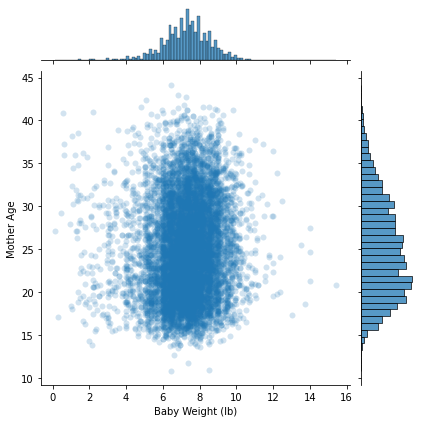

In [5]:
sns.jointplot(x=live['totalwgt_lb']
              , y=live['agepreg']
              , alpha=0.2
              , linewidth=0).set_axis_labels('Baby Weight (lb)', 'Mother Age')
plt.show()

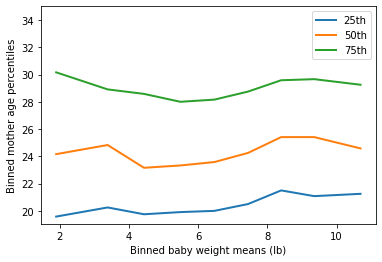

In [6]:
bins = np.arange(3, 11, 1)  # range should exclude the extreme values
indices = np.digitize(live.totalwgt_lb, bins)
groups = live.groupby(indices)

weight_grp_mean = [group.totalwgt_lb.mean() for i, group in groups]
age_grp_cdfs = [cdf_array(group.agepreg) for i, group in groups]

for percent in range(25, 76, 25):
    label = f'{percent}th'
    age = [cdf_percentile(cdf_grp, percent) for cdf_grp in age_grp_cdfs]
    plt.plot(weight_grp_mean, age, label=label, linewidth=2)
    plt.legend()
    
plt.xlabel('Binned baby weight means (lb)')
plt.ylabel('Binned mother age percentiles')
plt.ylim(top=35)
plt.show()

In [7]:
## See custom function above for calculation
cov_cor_stats(x=live['totalwgt_lb'], y=live['agepreg'])

{'Covariance': 0.5383945822432489,
 "Pearson's product-moment": 0.06883397035410906,
 "Spearman's rho": 0.09461004109658226,
 "Kendall's tau": 0.06406589660579405}

***

<br><br>

## Exercise 8-1

In this chapter we used $\bar{x}$ and median to estimate $\mu$, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and  to estimate $\sigma$, and found that $S^2$ is biased and $S^2_{n-1}$ is unbiased. Run similar experiments to see if $\bar{x}$ and median are biased estimates of μ. Also check whether $S^2$ or $S^2_{n-1}$ yields a lower MSE.

***

<b><u>Interpretation</u></b>: From the simulation ran for the variable 'Mother Age', the mean (24.9) and standard deviation (5.6) for the variable was used as parameters to generate 1000 hypothetical normal distribution samples with the same sample size. From the sampling distribution, it is likely that the mean and standard deviation from the initial sample are good estimators for the population and have low RMSE. The small confidence interval range for mean and standard deviation also give us better predictability for those population parameters. Interestingly, when the simulation was ran multiple times, the RMSE for $s^2_{n}$ vs. $s^2_{n-1}$ was very similar. In some simulations $s^2_{n}$ had a higher RMSE than $s^2_{n-1}$ and in other simulations was lower than $s^2_{n-1}$.

In [8]:
live_weights = live['agepreg']

dist_estimate(live_weights, rnd=5)

Simulated Distribution: NORMAL

Observed Sample Statistics
-------------------------
mean: 24.93613
median: 24.33
var: 30.84334
std: 5.55368
lamb: 0.0401
exp_est_median: 0.02849


RMSE
-------------------------
mean: 0.05613
median: 5.58526
var_n: 0.45645
var_n-1: 0.45636
std_n: 0.04111
std_n-1: 0.04109
lamb: 9e-05
exp_est_median: 0.02192


CI
-------------------------
mean: (24.84647, 25.05136, 0.20489)
median: (15.8084, 35.82244, 20.01405)
var_n: (30.03684, 31.74677, 1.70993)
var_n-1: (30.04016, 31.75028, 1.71012)
std_n: (5.48059, 5.63443, 0.15384)
std_n-1: (5.48089, 5.63474, 0.15385)
lamb: (0.03994, 0.04028, 0.00033)
exp_est_median: (0.02034, 0.04931, 0.02896)


MSE
-------------------------
mean: 0.00315
median: 31.19509
var_n: 0.20835
var_n-1: 0.20826
std_n: 0.00169
std_n-1: 0.00169
lamb: 0.0
exp_est_median: 0.00048


***

<br><br>

## Exercise 8-2

Suppose that you draw a sample with size $n = 10$ from an exponential distribution with $\lambda = 2$. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval. Repeat the experiment with a few different values of n and make a plot of standard error versus n.

***

<b><u>Interpretation</u></b>: As the sample size for Normal distribution estimation simulations gets larger, the Root Mean Squared Error (RMSE) gets smaller. For Lambda which is derived from the mean, the lower RMSE for larger sample sizes is due to the central limit theorem which states that if any population distribution is sampled that the mean of those samples will follow a Normal distribution. Both larger sample sizes and the number of samples taken will increase the confidence interval for the sample mean statistic.

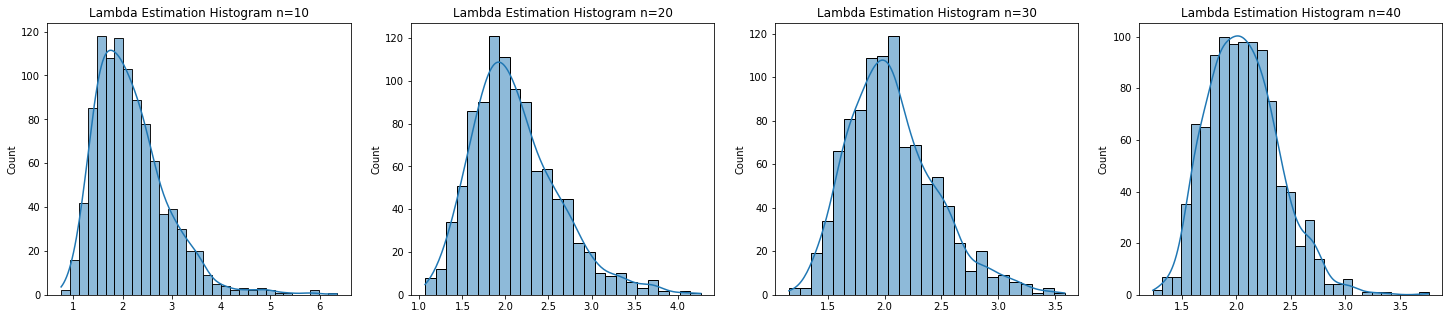

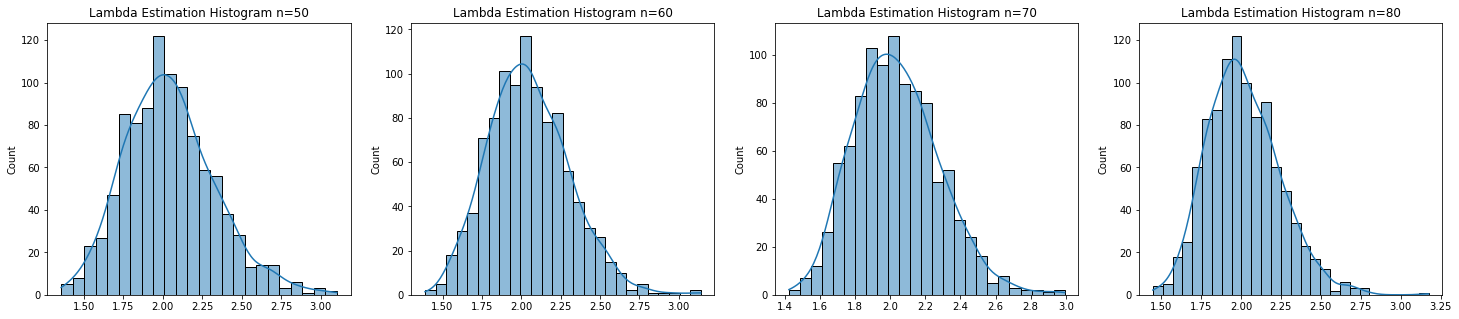

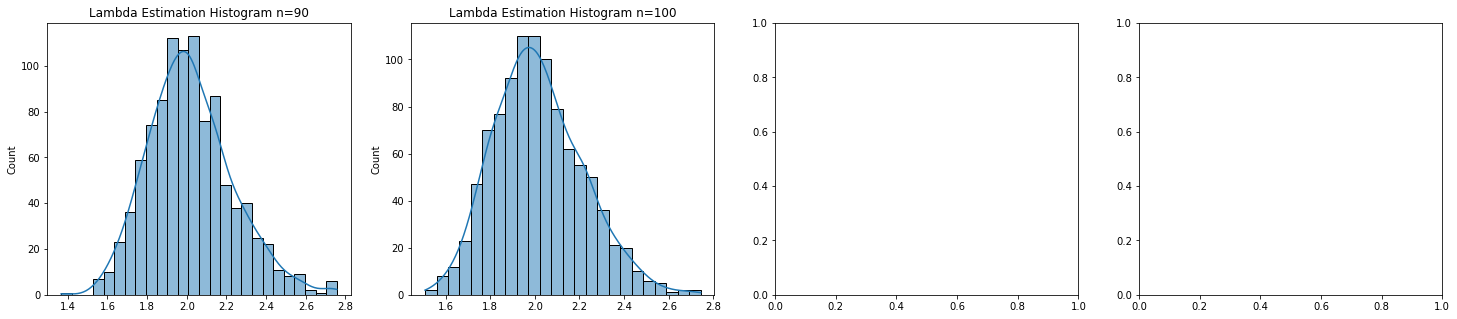

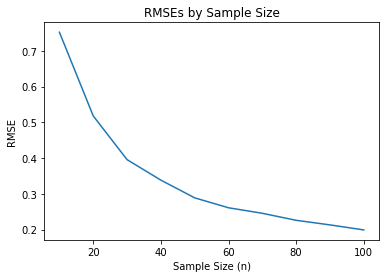

In [9]:
n = 10
lamb = 2
n_iterations = 100
n_step = 10
iterations = 1000

rmses = []
ci_lows = []
ci_highs = []
ci_rngs = []
lambs_dict = {}

for _ in range(n, n_iterations+1, n_step):
    lambs = []
    for _ in range(iterations):
        x = np.random.exponential(scale=(1/lamb), size=n)
        lambs.append(1/np.mean(x))
        
    lambs_dict[n] = lambs
    error2 = [(est_lamb - lamb)**2 for est_lamb in lambs]
    mse = np.mean(error2)
    rmses.append(math.sqrt(mse))
    cdf = cdf_array(np.asarray(lambs))
    ci_low = cdf_percentile(cdf, 5)
    ci_high = cdf_percentile(cdf, 95)
    ci_lows.append(ci_low)
    ci_highs.append(ci_high)
    ci_rngs.append(ci_high - ci_low)
    n += n_step
   

n_size = 10
graph_cnt = 1

for r in range(0,3):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25,5))
    for c in range(0,4):
        sns.histplot(lambs_dict[n_size], kde=True, ax=ax[c])
        ax[c].set_title(f'Lambda Estimation Histogram n={n_size}')
        n_size = n_size + 10
        graph_cnt += 1
        if graph_cnt > len(lambs_dict):
            break
    plt.show()

plt.plot([n_size for n_size in lambs_dict.keys()], rmses)
plt.title(f'RMSEs by Sample Size')
plt.xlabel('Sample Size (n)')
plt.ylabel('RMSE')
plt.show()





<br>

***

<br>

## Week 7 Practice

<br>

<span style="font-size:18px"><b>Jointplot with Jittered Values</b></span>

- Jittering turns discrete interval values into a continous values.

In [10]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.uniform(-jitter, +jitter, n) + values

jitter_ht = Jitter(heights, jitter=1.3)
jitter_wt = Jitter(weights, jitter=0.5)

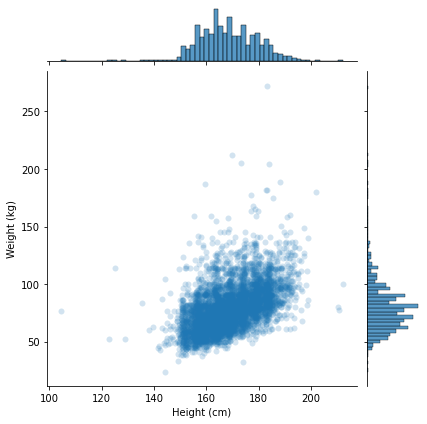

In [11]:
sns.jointplot(x=jitter_ht, y=jitter_wt, alpha=0.2, linewidth=0).set_axis_labels('Height (cm)', 'Weight (kg)')
plt.show()

<br><br>

<span style="font-size:18px"><b>Binned x(mean), y(percentile)</b></span>

<ol>
    <li> Create bins based on 'x' and group the DataFrame based on the bin values.
    <li> For each group in the DataFrame, get the mean for each group of 'x'
    <li> For each group in the DataFrame, get the 75th, 50th, and 25th percentile for each group of 'y'
    <li> Plot: x=mean of each group of 'x', y=percentiles for each group of 'y'
</ol>

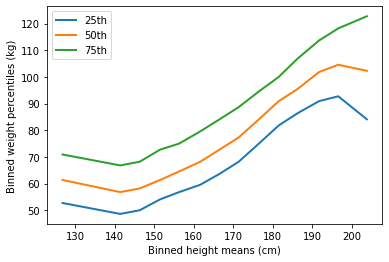

In [12]:
df2 = df.dropna(subset=['htm3','wtkg2'])
bins = np.arange(140, 201, 5)
indices = np.digitize(df2.htm3, bins)
groups = df2.groupby(indices)

height_grp_mean = [group.htm3.mean() for i, group in groups]
weight_grp_cdfs = [cdf_array(group.wtkg2) for i, group in groups]

for percent in range(25, 76, 25):
    label = f'{percent}th'
    weights = [cdf_percentile(cdf_grp, percent) for cdf_grp in weight_grp_cdfs]
    plt.plot(height_grp_mean, weights, label=label, linewidth=2)
    plt.legend()
    
plt.xlabel('Binned height means (cm)')
plt.ylabel('Binned weight percentiles (kg)')
plt.show()


<br><br>

<span style="font-size:18px"><b>Covariance & Correlation</b></span>

<ul>
    <li> <u>Covariance</u> measures how multiple variables vary together. The higher the covariance, the higher the correlation between the variables. This however is hard to interpret due to variables having different units or coming from different distributions. 
    <li> <u>Correlation</u> takes covariance and to make it more interpretable, we standardize each variable by dividing the covariance by the multiplication of each variables' standard deviation.
</ul>

<br>

<u>Covariance (sample)</u>:<br>
<span style="font-size:18px">$COV(X,Y)=\frac{1}{n-1}\sum(x_i-\bar{x})*(y_i-\bar{y})$</span>

<br>

<u>Covariance (population)</u>:<br>
<span style="font-size:18px">$COV(X,Y)=\frac{1}{n}\sum(x_i-\bar{x})*(y_i-\bar{y})$</span>

<br>

<u>Pearson's Product Moment Correlation (sample)</u>:<br>
<span style="font-size:18px">$r = \frac{COV(X,Y)}{s_x*s_y}=\frac{\frac{1}{n-1}\sum(x_i-\bar{x})*(y_i-\bar{y})}{s_x*s_y}$</span>

<br>

<u>Pearson's Product Moment Correlation (population)</u>:<br>
<span style="font-size:18px">$r = \frac{COV(X,Y)}{\sigma_x*\sigma_y}=\frac{\frac{1}{n}\sum(x_i-\bar{x})*(y_i-\bar{y})}{\sigma_x*\sigma_y}$</span>

<br>

***

<u>Spearman's rho</u>: Because Pearson's r assumes normality, if the distribution is not normal we can either attempt to use a function to make the distribution normal or perform a non-parametric correlation statistic. Spearman's rho is non-parametric so it does not assume normality. It does this by first converting creating new x & y variables from their ranks, then doing Pearson's r on the ranked variables.

<span style="font-size:18px">$\rho = \rho_{R(X), R(Y)}= \frac{COV(R(X), R(Y))}{\sigma_{R(X)} * \sigma_{R(Y)}}$</span><br>

<span style="font-size:12px">$R(X) = ranked\ X\ variable$</span><br>
<span style="font-size:12px">$R(Y) = ranked\ Y\ variable$</span><br>

<br>

***

<u>Kendall's tau</u>: Similar to Spearman's rho and is non-parametric. Spearman's rho is less computationally complex and is typically more popular and well known, Kendall's tau is arguablly more accurate than Spearman's rho. To calculate Kendall's tau:

<ol>
    <li> Create new variables for x & y based on rank.
    <li> Sort x_rank variable but make sure that the previous indices for each variable are still intact. The pair-values need to stay in sync but the x_rank needs to be sorted ascending.
    <li> Loop through y_rank to find the total number of concordant and discordant values. 
        <ol>
            <li> Concordant: number of values succeeding the current value that are greater than the current value
            <li> Discordant: number of values succeeding the current value that are less than the current value
            <li> In scipy.stats.kendalltau, ties are accounted for in the variable but are ignored when there is a pair-wise tie.
        </ol>
</ol>

<br>

<span style="font-size:18px">$\tau = \frac{(C - D)}{\sqrt{(C + D + T_x) * (C + D + T_y)}}$</span><br>

<span style="font-size:12px">$C = Concordant\ Pair\ Total$</span><br>
<span style="font-size:12px">$D = Discordant\ Pair\ Total$</span><br>
<span style="font-size:12px">$T_x = Ties\ in\ X$</span><br>
<span style="font-size:12px">$T_y = Ties\ in\ Y$</span><br>

In [13]:
## Example
x=[1,2,3,4,5,6]
y=[1,5,5,7,9,20]


## Custom function
print(cov_cor_stats(x, y, sample=False))


## Thinkstats function
thinkstats2.Cov(x, y), thinkstats2.Corr(x, y), thinkstats2.SpearmanCorr(x, y)


{'Covariance': 9.083333333333334, "Pearson's product-moment": 0.8930127395465893, "Spearman's rho": 0.9856107606091623, "Kendall's tau": 0.9660917830792959}


(9.083333333333334, 0.8930127395465893, 0.9856107606091623)

<br><br>

<span style="font-size:22px"><b>Estimation<b></span>

Choosing an estimation depends on the goal you're trying to answer. For example, if trying to minimize error mean may be better than median but if trying to get prediction right, median may be better. 

<span style="font-size:18px">$Mean\ Squared\ Error\ (MSE)=\frac{1}{m}\sum(\bar{x}-\mu)^2$</span>

<span style="font-size:12px">$m = number\ of\ samples\ (!!Not\ sample\ size!!)$</span>


In [14]:
def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return math.sqrt(mse)



def MeanError(estimates, actual):
    errors = [estimate - actual for estimate in estimates]
    return np.mean(errors)



def estimate1(n=7, m=1000):
    mu = 0
    sigma = 1
    
    means = []
    medians = []
    
    for _ in range(m):
        x = [np.random.normal(mu, sigma) for i in range(n)]
        xbar = np.mean(x)
        median = np.median(x)
        means.append(xbar)
        medians.append(median)
        
    print(f'rmse xbar: {RMSE(means, mu)}')
    print(f'rmse median: {RMSE(medians, mu)}')


    
def estimate2(n=7, m=1000):
    mu = 0
    sigma = 1
    
    estimates1 = []
    estimates2 = []
    
    for _ in range(m):
        x = [np.random.normal(loc=mu, scale=sigma) for i in range(n)]
        biased = np.var(x)
        unbiased = np.var(x, ddof=1)
        
        estimates1.append(biased)
        estimates2.append(unbiased)
        
    print(f'mean error biased: {MeanError(estimates1, sigma**2)}')  # not using degrees of freedom for samples underestimates the populatino variance
    print(f'mean error unbiased: {MeanError(estimates2, sigma**2)}')
    
    

def SimulateSample(mu=90, sigma=7.5, n=9, m=1000):
    means = []
    
    for _ in range(m):
        x = np.random.normal(loc=mu, scale=sigma, size=n)
        xbar = np.mean(x)
        means.append(xbar)
        
    cdf = cdf_array(np.asarray(means))
    ci = cdf_percentile(cdf, 5), cdf_percentile(cdf, 95)
    stderr = RMSE(means, mu)
    cdf_vals = cdf[0]
    cdf = cdf[1]
    
    return cdf_vals, cdf, ci, stderr


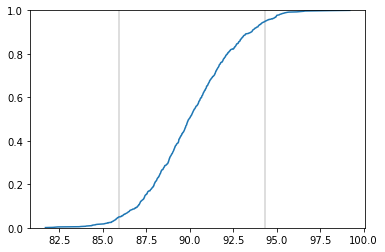


Confidence Interval: (85.9151533265243, 94.32381617439366)
Standard Error: 2.524927176154395



In [15]:
cdf_vals, cdf, ci, stderr = SimulateSample()
plt.vlines(ci, ymin=0, ymax=1, color='#d4d4d4')
plt.plot(cdf_vals, cdf)
plt.ylim((0,1))

plt.show()

print(f"""
Confidence Interval: {ci}
Standard Error: {stderr}
""")

In [16]:
## Simulating exponential distribution from sample statistics

def exp_estimate(sample, iterations=1000):
    n = sample.size
    mean = sample.mean()
    median = med(sample)
    lamb = 1/mean
    lm_median = math.log(2) / median
    
    means = []
    medians = []
    
    for _ in range(iterations):
        x = np.random.exponential(1/lamb, n)
        est_lamb = 1/np.mean(x)
        est_lm_median = math.log(2) / med(x)
        
        means.append(est_lamb)
        medians.append(est_lm_median)
        
    print(f'rmse lamb: {RMSE(means, lamb)}')
    print(f'rmse est median: {RMSE(medians, median)}')
    
    


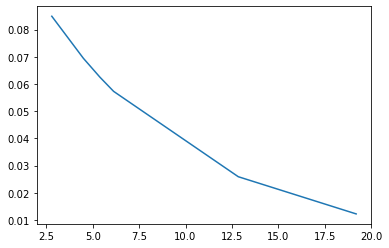

rmse lamb: 0.07277057373580549
rmse est median: 5.612102750954742


In [17]:
l2x = np.sort(np.asarray([5.384, 4.493, 19.198, 2.790, 6.122, 12.844]))
mean = sum(l2x) / len(l2x)
median = med(l2x)

## Maximum likelihood estimators
lamb = 1/mean
lm_median = math.log(2) / median


l2y = lamb*np.exp(-lamb*l2x)

plt.plot(l2x, l2y)

plt.show()

exp_estimate(l2x)
    